## Titanic: Determine Survivability from a Sinking Ship using Machine Learning

__Author:__ [Jocaz Ayrand G. Entico](https://www.linkedin.com/in/jocaz-entico-4675b9144/)

### Executive Summary
In this notebook, we are modeling the sinking of titanic and what are the possible variables and features to be considered for a certain passenger to survive the crash. We are implementing ensemble of machine learning models namely K-Nearest Neighbor, Logistic, Linear SVM, Nonlinear SVM, Decision Trees, Random Forest, and Gradient Boosting Method, and determine the top model with respect to the test accuracy for the Titanic data set. <br>

We are choosing the top three machine learning model that would be the best to be implemented in this data set. After using the Jude's Automated System (JUDAS), contains set of methods for implementing the machine learning algorithms, the top three machine learning classification algorithm with the highest test accuracy are **Gradient Boosting Method, Random Forest,** and **Decision Trees**. **Gradient Boosting Method** has a test accuracy of 80.78% with optimal number of max depth equal to $4$. Next, **Random Forest** has a test accuracy of 80.77 with $max\ depth=8$. Lastly, **Decision Trees** has test accuracy of 80.58% with $max\ depth=3$. The top predictor in determining survivability of each passenger is their sex.

### Let's Start!
Let's begin by providing all the libraries to be used in this notebook.

In [41]:
import pandas as pd
from collections import Counter
from sklearn.base import TransformerMixin
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pylab as plot
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### Data Description
The dataset is compsed of the information of the passengers in the Titanic and whether they survived the crash or not.

In [28]:
df = pd.read_excel('titanic.xls')

In [29]:
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,target
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,1
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,0
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,0
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,0


### Data Preprocessing

In [4]:
df.isnull().sum()

pclass         0
name           0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
target         0
dtype: int64

In [30]:
# df_features = df.drop(['cabin', 'name', 'ticket'], axis=1)
df_features = df.drop(['cabin', 'name', 'ticket'], axis=1)

We are removing the variables *name* and *ticket* in the data set since we cannot represent the string into numerical value without sacrificing the dimensionality of the data set for the purpose of the analysis to be performed later. Additionally, the variable *ticket* is correlated and derivable from the variable *price*. In the case of the variable *cabin*, majority of the entry are missing so in order to resolve this, we are dropping the the variable cabin since it will be biased if we try to impute the data that is missing. On the other hand, we will be imputing the missing values for *age* by getting the mean. The same goes for the missing values on the other variables.

### Methods Definition
We created the class *DataFrameImputer* to fill in the missing values in the variables age, fare, and embarked in the given data set.

In [31]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [32]:
df_features = DataFrameImputer().fit_transform(df_features)
df_features.head()

,pclass,sex,age,sibsp,parch,fare,embarked,target
0,1,female,29.0000,0,0,211.3375,S,1
1,1,male,0.9167,1,2,151.5500,S,1
2,1,female,2.0000,1,2,151.5500,S,0
3,1,male,30.0000,1,2,151.5500,S,0
4,1,female,25.0000,1,2,151.5500,S,0


In [33]:
df_features.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
target      0
dtype: int64

In [34]:
final_features = pd.get_dummies(df_features, drop_first=True)
final_features.head()

,pclass,age,sibsp,parch,fare,target,sex_male,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,1,0,0,1
1,1,0.9167,1,2,151.5500,1,1,0,1
2,1,2.0000,1,2,151.5500,0,0,0,1
3,1,30.0000,1,2,151.5500,0,1,0,1
4,1,25.0000,1,2,151.5500,0,0,0,1


We converted the *embarked* variable by one-hot enconding, the value **C** for the variable *embarked* does not show in the columns of the new data frame which means that the combination of embarked_Q = 0 and embarked_S = 0 show that the value of the variable *embraked* is **C**.
- C = Cherbourg
- Q = Queenstown
- S = Southampton

### Data Exploration

/home/jocaz/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/jocaz/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/jocaz/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/jocaz/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/jocaz/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keep

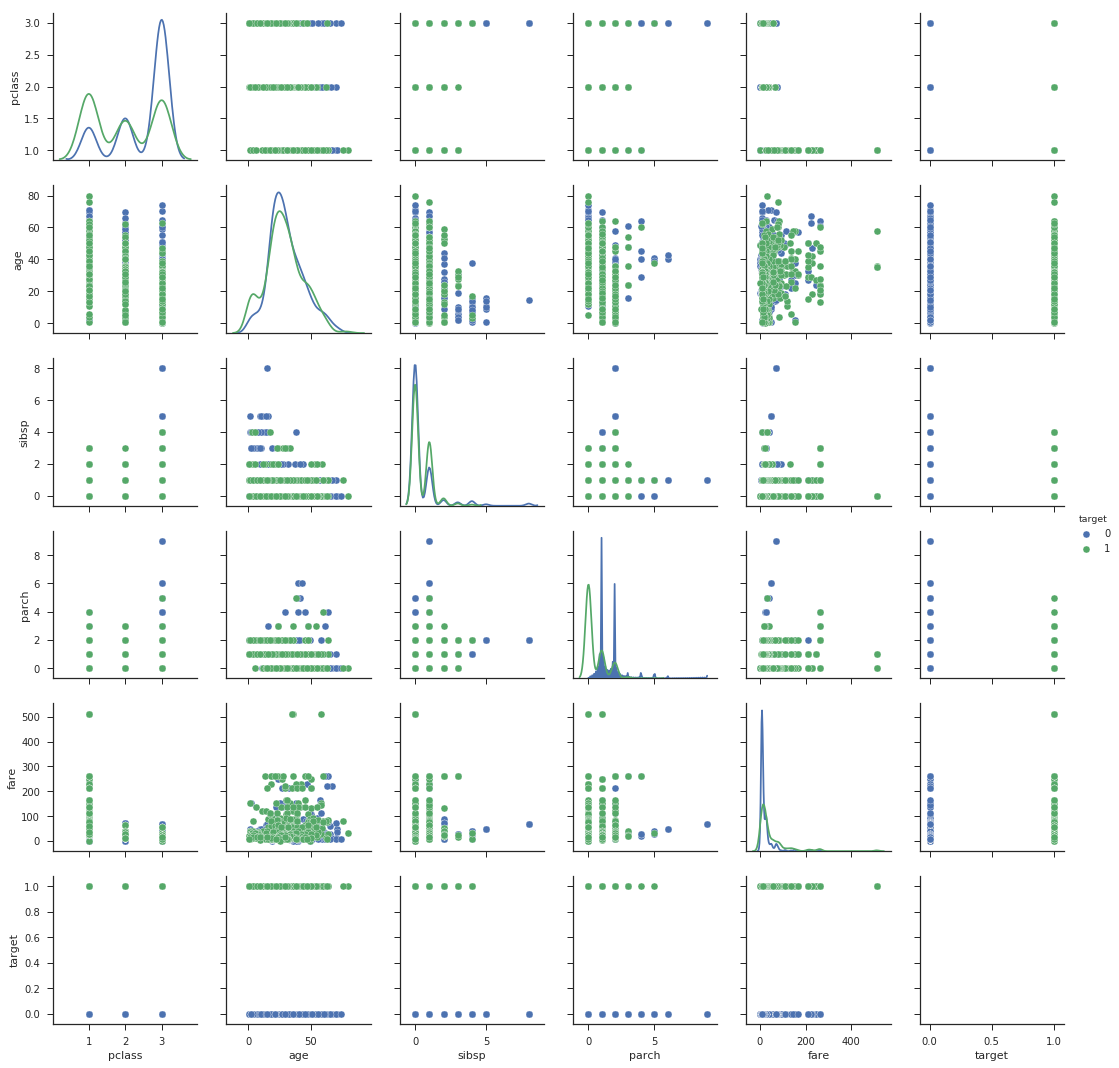

In [10]:
sns.set(style="ticks")

sns.pairplot(df, hue="target", diag_kind='kde')

pass

We can observe at the pairplot that their is no clear demarcation on the features in the data set pairwise. We can look the relationship of each variable to one another after we determine the optimal machine learning model to be used with the highest test accuracy.

In [11]:
state_counts = Counter(df['target'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
num = (df_state[0]/df_state[0].sum())**2

Population per class:      0
1  500
0  809



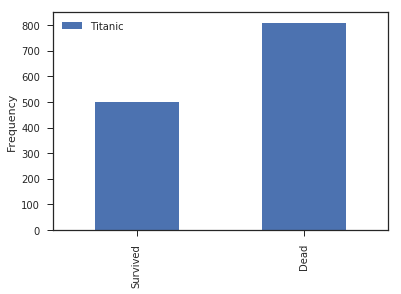

In [12]:
ax = df_state.plot(kind='bar')
ax.legend(['Titanic'])
ax.set_ylabel('Frequency')
print("Population per class: {}\n".format(df_state))
ax.set_xticklabels(['Survived', 'Dead']);

In this dataset, there are __500__ individuals who **Survived**, and __809__ who individuals who did not make it after the Titanic incident.

In [13]:
print("1.25 * Proportion Chance Criterion: {}%".format(1.25*100*num.sum()))

1.25 * Proportion Chance Criterion: 65.98271296851263%


The minimum accuracy a classifier must have for the classification is 65.98% for it to be considered significant.

### Model Selection

We will be using the Jude's Automated System (JUDAS) for determining the top 3 machine learning model for this specific data set.

In [42]:
Number_trials=50

def train_knn(X, y):
    score_train = []
    score_test = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

        neighbors_settings = range(1,70)
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:   
            clf = KNeighborsClassifier(n_neighbors=n_neighbors) # build the model 
            clf.fit(X_train, y_train)    
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)   
        
    score = np.mean(score_test, axis=0)
    #return n_neighbor, accuracy
    return ['kNN', np.amax(score), 'N_Neighbor = {0}'.format(np.argmax(score)+1), 'Not Now']

def train_logistic(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    #C = [0.01]

    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            lr = LogisticRegression(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            if alpha_run == 0.1:
                coefs=lr.coef_ 
                weighted_coefs.append(coefs) #append all the computed coefficients per trial
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
    
    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials 
    #print(mean_coefs) 
    score = np.mean(score_test, axis=0)
    #return score.shape
    #coefs = lr.coef_
    #return C value, accuracy, column/feature name
    
    if scaler == 'ON':
        top_predictor = 'DEBUGGING'
    if scaler == 'OFF':
        top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
        abs_mean_coefs = np.abs(mean_coefs[0,:])
        coefs_count = len(abs_mean_coefs)
#         fig, ax = plt.subplots(figsize=(3,5))
#         ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
#         #ax.barh(np.arange(coefs_count), mean_coefs[0, np.argsort(abs_mean_coefs)])
#         ax.set_yticks(np.arange(coefs_count))
#         ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
        
    return ['Logistic ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor]

def train_svm(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    #C = [0.01]
    
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False).fit(X_train, y_train)
            if reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            if alpha_run == 0.1:
                coefs = svc.coef_
                weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    
    #if scaler == 'ON':
    #    top_predictor = 'DEBUGGING'
    #if scaler == 'OFF':
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[0,:])
    coefs_count = len(abs_mean_coefs)
#     fig, ax = plt.subplots(figsize=(3,5))
#     ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        #ax.barh(np.arange(coefs_count), mean_coefs[0, np.argsort(abs_mean_coefs)])
#     ax.set_yticks(np.arange(coefs_count))
#     ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
        #print(X.columns(np.arg(np.abs(mean_coefs)))
        #print(np.abs(mean_coefs))
    #return score
    #return C value, accuracy, column/feature name
    #y_pred = lsvc_l1.predict(X_test)
    #confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    #print(confmat)
    return ['Linear SVM ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor]


def train_Nsvm(X, y, reg):
    #CC = [.1]
    #C = [0.01]
    CC = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]

    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in CC:
            svm = SVC(kernel='rbf', gamma=alpha_run, C=10)
            svc=svm.fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            #if alpha_run == 0.01:
            #    coefs = svc.coef_
             #   weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    top_predictor ='Not Now'
   
    return ['Nonlinear SVM ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(CC[np.argmax(score)]), top_predictor]


def train_Nsvmpoly(X, y, reg):

    CC = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]

    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in CC:
            svm = SVC(kernel='poly',degree=2,coef0=1, C=alpha_run)
            svc=svm.fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            #if alpha_run == 0.01:
            #    coefs = svc.coef_
             #   weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    
    top_predictor='Not Now'
    return ['Nonlinear SVM ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(CC[np.argmax(score)]), top_predictor]

def train_trees(X, y):
    score_train = []
    score_test = []
    
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        
        maxdepth_settings = range(1, 15)
        
        for depth in maxdepth_settings:   
            reg = DecisionTreeClassifier(random_state=0, max_depth=depth) # build the model 
            reg.fit(X_train, y_train) #clf = KNeighborsClassifier(n_neighbors=n_neighbors    
            training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy  
            test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy  
            
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
    
    score = np.mean(score_test, axis=0)
    
    return ['Decision Trees', np.amax(score), \
            'Depth = {0}'.format(np.argmax(score)+1), 'Not Now']

def train_forest(X, y):
    score_train = []
    score_test = []
    
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        max_depth_settings = range(1, 10) # try max_depth from 1 to 10

        for depth in max_depth_settings:   
            forest = RandomForestClassifier(max_depth=depth, random_state=0, n_estimators=100)
            forest.fit(X_train, y_train)
            training_accuracy.append(forest.score(X_train, y_train)) # record training set accuracy
            test_accuracy.append(forest.score(X_test, y_test))   # record generalization accuracy
            
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
        
    score = np.mean(score_test, axis=0)
    
    return ['Random Forest', np.amax(score), \
            'Depth = {0}'.format(np.argmax(score)+1), 'Not Now']

def train_gbm(X, y):
    score_train = []
    score_test = []
    
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        depth_settings = range(1, 15) # try depth from 1 to 15
        
        for depth in depth_settings:   
            forest = GradientBoostingClassifier(max_depth=depth, random_state=0, learning_rate=0.1)
            forest.fit(X_train, y_train)
            training_accuracy.append(forest.score(X_train, y_train)) # record training set accuracy
            test_accuracy.append(forest.score(X_test, y_test))   # record generalization accuracy
        
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
        
    score = np.mean(score_test, axis=0)
        
    return ['Gradient Boosted Method', np.amax(score), \
            'Depth = {0}'.format(np.argmax(score)+1), 'Not Now']
        

In [43]:
X = final_features.drop('target', axis=1)
y = df['target']

scaler='OFF'

a = train_knn(X,y)
print(a)
b = train_logistic(X,y,reg='l2')
print(b)
c = train_logistic(X,y,reg='l1')
print(c)
d = train_svm(X,y,reg='l2')
print(d)
e = train_svm(X,y,reg='l1')
print(e)
f = train_Nsvm(X,y,reg='rbf')
print(f)
g = train_trees(X,y)
print(g)
h = train_forest(X,y)
print(h)
i = train_gbm(X,y)
print(i)

['kNN', 0.695121951219512, 'N_Neighbor = 14', 'Not Now']
['Logistic (l2)', 0.7840243902439024, 'C = 0.75', 'sex_male']
['Logistic (l1)', 0.7850609756097563, 'C = 0.2', 'sex_male']
['Linear SVM (l2)', 0.7806097560975611, 'C = 0.01', 'sex_male']
['Linear SVM (l1)', 0.786158536585366, 'C = 0.1', 'sex_male']


/home/jocaz/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jocaz/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['Nonlinear SVM (rbf)', 0.740731707317073, 'C = 0.01', 'Not Now']
['Decision Trees', 0.8055487804878048, 'Depth = 3', 'Not Now']
['Random Forest', 0.8075, 'Depth = 8', 'Not Now']
['Gradient Boosted Method', 0.8077439024390246, 'Depth = 2', 'Not Now']


In [44]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c
df2.loc[3] = d
df2.loc[4] = e
df2.loc[5] = f
df2.loc[6] = g
df2.loc[7] = h
df2.loc[8] = i
df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,kNN,0.695122,N_Neighbor = 14,Not Now
1,Logistic (l2),0.784024,C = 0.75,sex_male
2,Logistic (l1),0.785061,C = 0.2,sex_male
3,Linear SVM (l2),0.780610,C = 0.01,sex_male
4,Linear SVM (l1),0.786159,C = 0.1,sex_male
5,Nonlinear SVM (rbf),0.740732,C = 0.01,Not Now
6,Decision Trees,0.805549,Depth = 3,Not Now
7,Random Forest,0.807500,Depth = 8,Not Now
8,Gradient Boosted Method,0.807744,Depth = 2,Not Now


After feeding the data set to different machine learning classification algorithm, we can observe that the top predictor is **sex_male**. Furthermore, there are three machine learning method that exceeds the proportion chance criterion which is greater than $65.98\%$ and these are K-Nearest Neighbor, Logistic Regression, and Linear Support Vector Machine.

### Scaling the Data
We are implementing two types of scaler namely **MinMaxScaler** and **StandardScaler** which could improve the test accuracy of the machine learning methods used because there are differences in the units of the variable of the original data set.

**MinMaxScaler** <br>
The data is scaled from $0$ to $1$ based on the minimum value and maximum value of each variable.

In [45]:
%%time

X = final_features.drop('target', axis=1)
dummy2=X
y = df['target']

scaler='OFF'

sscaler = MinMaxScaler()
X = sscaler.fit_transform(X)
X = pd.DataFrame(X, columns=dummy2.columns)
#X.head()

a = train_knn(X,y)
print(a)
b = train_logistic(X,y,reg='l2')
print(b)
c = train_logistic(X,y,reg='l1')
print(c)
d = train_svm(X,y,reg='l2')
print(d)
e = train_svm(X,y,reg='l1')
print(e)
f = train_Nsvm(X,y,reg='rbf')
print(f)
g = train_trees(X,y)
print(g)
h = train_forest(X,y)
print(h)
i = train_gbm(X,y)
print(i)

['kNN', 0.7959146341463417, 'N_Neighbor = 44', 'Not Now']
['Logistic (l2)', 0.7839024390243903, 'C = 0.4', 'sex_male']
['Logistic (l1)', 0.7831097560975607, 'C = 0.4', 'sex_male']
['Linear SVM (l2)', 0.7846341463414634, 'C = 0.4', 'sex_male']
['Linear SVM (l1)', 0.7845121951219513, 'C = 0.4', 'sex_male']


/home/jocaz/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jocaz/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['Nonlinear SVM (rbf)', 0.8051829268292682, 'C = 1', 'Not Now']
['Decision Trees', 0.8055487804878048, 'Depth = 3', 'Not Now']
['Random Forest', 0.807378048780488, 'Depth = 8', 'Not Now']
['Gradient Boosted Method', 0.8077439024390246, 'Depth = 2', 'Not Now']
CPU times: user 11min 17s, sys: 6.43 s, total: 11min 23s
Wall time: 11min 55s


In [46]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c
df2.loc[3] = d
df2.loc[4] = e
df2.loc[5] = f
df2.loc[6] = g
df2.loc[7] = h
df2.loc[8] = i
df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,kNN,0.795915,N_Neighbor = 44,Not Now
1,Logistic (l2),0.783902,C = 0.4,sex_male
2,Logistic (l1),0.783110,C = 0.4,sex_male
3,Linear SVM (l2),0.784634,C = 0.4,sex_male
4,Linear SVM (l1),0.784512,C = 0.4,sex_male
5,Nonlinear SVM (rbf),0.805183,C = 1,Not Now
6,Decision Trees,0.805549,Depth = 3,Not Now
7,Random Forest,0.807378,Depth = 8,Not Now
8,Gradient Boosted Method,0.807744,Depth = 2,Not Now


**StandardScaler** <br>
The data is scaled based on the mean and standard deviation of the each variable.

In [47]:
%%time

X = final_features.drop('target', axis=1)
dummy2=X
y = df['target']

scaler='OFF'

sscaler = StandardScaler()
X = sscaler.fit_transform(X)
X = pd.DataFrame(X, columns=dummy2.columns)
#X.head()

a = train_knn(X,y)
print(a)
b = train_logistic(X,y,reg='l2')
print(b)
c = train_logistic(X,y,reg='l1')
print(c)
d = train_svm(X,y,reg='l2')
print(d)
e = train_svm(X,y,reg='l1')
print(e)
f = train_Nsvm(X,y,reg='rbf')
print(f)
g = train_trees(X,y)
print(g)
h = train_forest(X,y)
print(h)
i = train_gbm(X,y)
print(i)

['kNN', 0.8043292682926829, 'N_Neighbor = 12', 'Not Now']
['Logistic (l2)', 0.7828048780487806, 'C = 3', 'sex_male']
['Logistic (l1)', 0.7832926829268289, 'C = 0.1', 'sex_male']
['Linear SVM (l2)', 0.784390243902439, 'C = 0.01', 'sex_male']
['Linear SVM (l1)', 0.7850609756097561, 'C = 0.1', 'sex_male']


/home/jocaz/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jocaz/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['Nonlinear SVM (rbf)', 0.8028048780487805, 'C = 0.1', 'Not Now']
['Decision Trees', 0.8057926829268293, 'Depth = 3', 'Not Now']
['Random Forest', 0.8076829268292685, 'Depth = 8', 'Not Now']
['Gradient Boosted Method', 0.8078048780487807, 'Depth = 4', 'Not Now']
CPU times: user 11min 12s, sys: 1.8 s, total: 11min 14s
Wall time: 11min 19s


In [48]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c
df2.loc[3] = d
df2.loc[4] = e
df2.loc[5] = f
df2.loc[6] = g
df2.loc[7] = h
df2.loc[8] = i
df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable
0,kNN,0.804329,N_Neighbor = 12,Not Now
1,Logistic (l2),0.782805,C = 3,sex_male
2,Logistic (l1),0.783293,C = 0.1,sex_male
3,Linear SVM (l2),0.784390,C = 0.01,sex_male
4,Linear SVM (l1),0.785061,C = 0.1,sex_male
5,Nonlinear SVM (rbf),0.802805,C = 0.1,Not Now
6,Decision Trees,0.805793,Depth = 3,Not Now
7,Random Forest,0.807683,Depth = 8,Not Now
8,Gradient Boosted Method,0.807805,Depth = 4,Not Now


Comparing the two scaling that we implemented, we are considering the **StandardScaler** since the difference in the test accuracy between is nearly negligible however the parameters used in different machine learning algorithm is simpler rather than **MinMaxScaler**.

### Results and Discussion
- **K-Nearest Neighbor** <br>
The target variable is predicted by the nearest k number of points in the n-dimensional plane. The result shows that the optimal number of neighbors is $k=12$ which means that it calculates the prediction of the test data by considering the 12 nearest neighbor in the training data. K-Nearest Neighbor has test accuracy of $80.43\%$
- **Logistic Regression (L2 regularization)** <br>
In logistic regression, the state of the target variable is determined using the sigmoid function. The logistic regression uses sigmoid function because the values would be trap to either 0 or 1 if we are not using sigmoid function. The parameter **C** determines the strength of the regularization to be applied on the model. The result shows that the optimal value for **C** is equal to $3$. Logistic Regression (L2 regularization) has test accuracy of $78.28\%$.
- **Logistic Regression (L1 regularization)** <br>
The only difference between the previous one is the one the data is regularize. With L2 regularization, we are considering the Euclidean distance. On the other hand, with L1 regularization, we are considering the Manhanttan distance. The result show that the optimal value for **C** is equal to $0.1$. Logistic Regression (L1 regularization) has test accuracy of $78.33\%$.
- **Linear Support Vector Machine** <br>
In Linear SVM, the main objective is to optimize the margin, distance between the separating hyperplane, of the target variable that we are trying to predict. The parameter **C** is used to control the penalty for misclassification. For L2 regularization, the test accuracy is equal to $78.44\%$ with $C=0.01$. While for L1 regularization, the test accuracy is equal to $78.51\%$ with $C=0.1$.
- **Nonlinear Support Vector Machine** <br>
The only difference between linear and nonlinear support vector machine is the kernel to be used in separating the target variable that we are predicting. Instead of using a line, nonlinear SVM uses radial basis function (RBF) in optimizing the margin between the data points. The result show that the test accuracy for nonlinear SVM is equal to $80.28\%$ with $C=0.1$.
- **Decision Trees** <br>
Decision trees is a network that contains the heirarchy of each predictor in determining the correct classification for the target variable. The top node of the decision tree is the top predictor and the number of layer before arriving into the classification is called depth. According to the result, the test accuracy is equal to $80.58\%$ with $depth=3$.
- **Random Forest** <br>
Random forest is used in order to remove the bias of decision in overfitting. The idea behind random forest is creating trees and reduce the amount of overfitting by getting the mean of the result of the decision trees. The result shows that the accuracy is equal to $80.77\%$ with max depth for the decision trees equal to $8$.
- **Gradient Boosting Method** <br>
Like random forest, Gradient Boosting Method combines multiple decision trees in predicting the classfication of the target variable. However, gradient boosting method has a parameter *learning rate* which tries to correct the mistakes of the previous tree in order to yield a better test accuracy. The result show that the test accuracy is equal to $80.78\%$ with max depth for the decision trees equal to $4$.

### Acknowledgement
I would like to acknowledge Prof. Chris Monterola for providing the templates for the codes in implementing the machine learning classification algorithm and teaching the concepts applied in different machine learning algorithm. I would also like to acknowledge Jude Teves for sharing the automated system named JUDAS that help in minimizing the amount of work to be done in finding good results for this notebook.